In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import shutil

In [4]:
base_dir=r'./data/4weather'  #定义基本目录，利用os帮助我们生成目录文件夹
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
if not os.path.isdir(base_dir): #如果该目录不存在则创建该目录
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(test_dir)

In [5]:
#在train和test目录下创建多个类别文件夹
specises=['cloudy','rain','shine','sunrise']
for train_or_test in ['train','test']:
    for spec in specises:
        tempdir=base_dir+'/'+train_or_test+'/'+spec
        #print(tempdir)
        if not os.path.isdir(tempdir):
            os.mkdir(os.path.join(base_dir,train_or_test,spec))

In [6]:
image_dir=r'./dataset2'

In [7]:
#通过os来将dataset2里面的图片分配到base目录分类文件夹里面
for i,image in enumerate(os.listdir(image_dir)):
    for spec in specises:#对于每一张图片，遍历每个类别，判断该图片属于哪一类
        if spec in image:
            s=os.path.join(image_dir,image)#获取该图片的目录
            if i%5==0:#如果编号为5的倍数则
                d=os.path.join(base_dir,'test',spec,image)#将要放置该图片的目录，测试集中
            else:
                d=os.path.join(base_dir,'train',spec,image)#将要放置该图片的目录，训练集中
            shutil.copy(s,d)#把图片从s目录拷贝到d目录下

In [8]:
#打印出每个类别的图片个数
for train_or_test in ['train','test']:
    for spec in specises:
        print(train_or_test,spec,len(os.listdir(os.path.join(base_dir,train_or_test,spec))))

train cloudy 240
train rain 172
train shine 202
train sunrise 286
test cloudy 60
test rain 43
test shine 51
test sunrise 71


# 读取预处理图片并创建Dataset

In [9]:
from torchvision import transforms

In [10]:
#建立transform，需要对图片进行预处理
transform=transforms.Compose([
                transforms.Resize((96,96)),#缩小了图片
                transforms.ToTensor(),#把channel放最前面，把图片转化为tensor类型，还把数据进行归一化-1到1之间
                transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])#标准化
])

# 创建dataset

In [11]:
train_ds=torchvision.datasets.ImageFolder(
    train_dir,
    transform=transform
)
test_ds=torchvision.datasets.ImageFolder(
    test_dir,
    transform=transform
)

In [12]:
train_ds.classes#可以获得读取图片的类别
train_ds.class_to_idx#获得每种类别的编号

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [13]:
len(train_ds),len(test_ds)

(900, 225)

# 创建dataloader

In [14]:
BATCHSIZE=16
train_dl=torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCHSIZE,
    shuffle=True
)

test_dl=torch.utils.data.DataLoader(
    test_ds,
    batch_size=BATCHSIZE
)

In [15]:
imgs,labels=next(iter(train_dl))

In [16]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [17]:
imgs[0].shape

torch.Size([3, 96, 96])

In [18]:
#通过permute可以改变维度的顺序
im=imgs[0].permute(1,2,0)
im.shape

torch.Size([96, 96, 3])

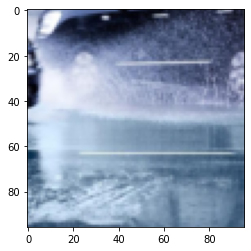

In [19]:
#绘图图片数据分布，并展示该图
im=(im+1)/2
plt.imshow(im)

In [20]:
labels[0]

tensor(1)

In [21]:
id_to_class=dict((v,k)for k, v in train_ds.class_to_idx.items())
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

# 绘制多张图片

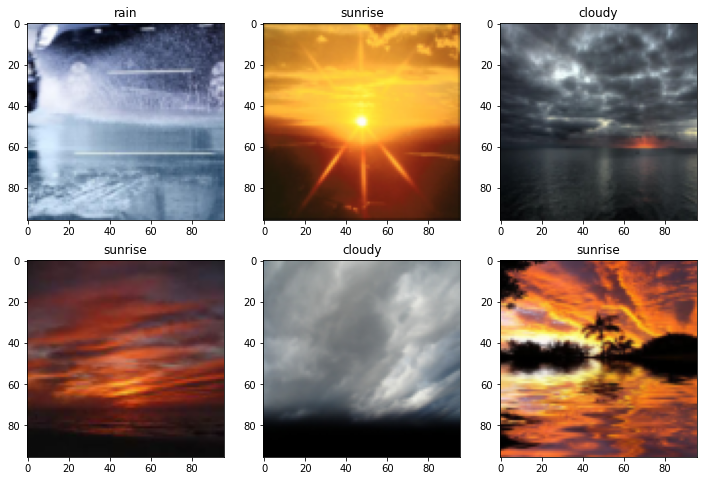

In [22]:
plt.figure(figsize=(12,8))
for i ,(img,label) in enumerate(zip(imgs[:6],labels[:6])):
    img=(img.permute(1,2,0).numpy()+1)/2
    plt.subplot(2,3,i+1)#画到2行3列的第i个位置上
    plt.title(id_to_class.get(label.item()))#并获得其对应的类别,每幅图上方都显示其类别作为标题
    plt.imshow(img)

# 构建网络层

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,16,3)#第一个卷积层
        self.conv2=nn.Conv2d(16,32,3)
        self.conv3=nn.Conv2d(32,64,3)
        self.pool=nn.MaxPool2d(2,2)#一个池化层
        self.fc1=nn.Linear(64*10*10,1024)#一个线性层
        self.fc2=nn.Linear(1024,4)
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        x=F.relu(self.conv3(x))
        x=self.pool(x)
        print(x.size())
        x=x.view(-1,64*10*10)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [24]:
model=Net()
preds=model(imgs)

torch.Size([16, 64, 10, 10])


D:\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [25]:
preds.shape#有十六张图片，每张图片有4类

torch.Size([16, 4])

In [26]:
torch.argmax(preds,1)#找每行值最大对应的index

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# 把模型放到GPU上

In [27]:
if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
# 损失函数
loss_fn=nn.CrossEntropyLoss()
#优化器
optim=torch.optim.Adam(model.parameters(),lr=0.01)

# 训练函数

In [28]:
def fit(epoch,model,trainloader,testloader):
    correct=0
    total=0
    running_loss=0
    for x,y in trainloader:
        if torch.cuda.is_available():
            x,y=x.to('cuda'),y.to('cuda')
        y_pred=model(x)
        loss=loss_fn(y_pred,y)#计算损失
        optim.zero_grad()#清空梯度
        loss.backward()#向前传播
        optim.step()
        with torch.no_grad():
            y_pred=torch.argmax(y_pred,dim=1)#得到每个batch的预测标签
            correct+=(y_pred==y).sum().item()#得到预测正确的总数
            total+=y.size(0)
            running_loss+=loss.item()

    epoch_loss=running_loss/len(trainloader.dataset)#计算平均epochloss
    epoch_acc=correct/total#计算准确率

    test_correct=0
    test_total=0
    test_running_loss=0

#计算测试集的数据时，无需计算梯度
    with torch.no_grad():
        for x,y in testloader:
            if torch.cuda.is_available():
                x,y=x.to('cuda'),y.to('cuda')
            y_pred=model(x)
            loss=loss_fn(y_pred,y)
            y_pred=torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred==y).sum().item()
            test_total+=y.size(0)
            test_running_loss+=loss.item()

    epoch_test_loss=test_running_loss/len(testloader.dataset)
    epoch_test_acc=test_correct/test_total

    print('epoch:',epoch,
            'loss', round(epoch_loss,3),
            'accuracy:',round(epoch_acc,3),
            'test_loss: ',round(epoch_test_loss,3),
            'test_accuracy:',round(epoch_test_acc,3)
            )
    
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [ ]:
epochs=30
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc=fit(epoch,model,train_dl,test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_loss.append(epoch_test_acc)
    